# Phylogenetic plotting — **Alpha-only**, GMM selection, clean layout

This notebook builds a compact, publication-ready multipanel figure from BLAST hits:
- Filters **Alpha** subtype only
- Selects hits per frame using a **Gaussian Mixture Model (GMM)** on (Identity, Coverage, −log10(E))
- Robustly picks *A. purpuratus* query sequences for **Frame −2/−3**
- Limits tree size by **representatives per species** (optional)
- Aligns with **Clustal Omega** and draws **Neighbor-Joining** tree(s)
- Final figure:
  - **A–C**: QC boxplots (Identity, Coverage, E-value) by frame (Alpha-only), highlighting the **best frame**
  - **D**: one large tree for the **best frame**

> Edit the paths in the first cell if needed.


In [1]:
# --- Paths & config (EDIT if needed) ---
from pathlib import Path

# Inputs
PATH_HITS   = Path("../external_results_tools/4J6C457P013-Alignment-HitTable.csv")  # BLAST HitTable
PATH_SEQDMP = Path("../external_results_tools/seqdump.txt")                         # subject sequences (FASTA)
PATH_TRANS  = Path("../external_results_tools/translate.txt")                       # translated frames (*A. purpuratus*)

# Working dirs / outputs
DIR_TMP     = Path("../tmp");           DIR_TMP.mkdir(exist_ok=True, parents=True)
DIR_FIG     = Path("../figures_paper"); DIR_FIG.mkdir(exist_ok=True, parents=True)

FA_F2       = DIR_TMP / "frame2.fasta"
FA_F3       = DIR_TMP / "frame3.fasta"
ALN_F2      = DIR_TMP / "aligned_frame2.fasta"
ALN_F3      = DIR_TMP / "aligned_frame3.fasta"

OUT_PNG     = DIR_FIG / "phylo_alpha_gmm_bestframe.png"
OUT_PDF     = DIR_FIG / "phylo_alpha_gmm_bestframe.pdf"

# Tree size control (representatives)
PER_SPECIES = 1   # representatives per species
K_MAX       = 50  # max total sequences in the tree

print("Using HitTable:", PATH_HITS.resolve())
print("TMP:", DIR_TMP.resolve())
print("FIG:", OUT_PNG.resolve())

Using HitTable: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/external_results_tools/4J6C457P013-Alignment-HitTable.csv
TMP: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/tmp
FIG: /home/david/Desktop/colabs/maya_gianina_colabs/PI5P4K_analysis/figures_paper/phylo_alpha_gmm_bestframe.png


In [2]:
# --- Imports ---
import re, warnings, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

/home/david/miniconda3/envs/training_models_pi/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
# --- Helper functions ---
from unicodedata import normalize

def norm_text(s:str)->str:
    return normalize("NFKC", str(s)).replace("’","'").strip()

def get_subtype(description: str) -> str:
    d = (description or "").upper()
    return "Alpha" if "ALPHA" in d else "NA"

def get_organism(description: str) -> str:
    # expects "... [Genus species]"
    try:
        org = description.split("[")[1].split("]")[0].strip().replace(" ", "-")
    except Exception:
        org = "NA"
    return org

def check_entries_to_ignore(description: str) -> bool:
    d = (description or "").lower()
    bad = ["hypothetical","unnamed","uncharacterized","putative","partial",
           "low quality","fragment","pseudogene"]
    return any(b in d for b in bad)

def prepare_sequences_for_MSA(dataset: pd.DataFrame, sequence_input: str, id_seq: str, name_export: Path):
    records = []
    for _, row in dataset.iterrows():
        sequence = row["sequence"]
        acc = row["Accession"]
        parts = (row.get("Organism","NA") or "NA-NA").split("-")
        organism = f"{parts[0][0]}.-{parts[1]}" if len(parts)>1 and parts[0] else parts[0]
        subtype = row.get("Subtype","NA")
        rec_id  = f"[{acc}]-{organism}|{subtype}"
        records.append(SeqRecord(Seq(sequence), id=rec_id, description=""))
    records.append(SeqRecord(Seq(sequence_input), id=id_seq, description=""))
    SeqIO.write(records, str(name_export), "fasta")

def run_msa(aligned_file: Path, fasta_file: Path):
    cl = ClustalOmegaCommandline(infile=str(fasta_file), outfile=str(aligned_file),
                                 verbose=True, auto=True, force=True)
    print(f"Running MSA -> {aligned_file}")
    stdout, stderr = cl()

def build_tree_from_alignment(aligned_file: Path):
    alignment = AlignIO.read(str(aligned_file), "fasta")
    calculator = DistanceCalculator("blosum62")
    constructor = DistanceTreeConstructor()
    dm = calculator.get_distance(alignment)
    return constructor.nj(dm)

def draw_tree_ax(tree, ax, title:str):
    # work on a copy; remove Inner* labels and rename query tip to 'A. purpuratus'
    t = copy.deepcopy(tree)
    for clade in t.find_clades(order="preorder"):
        name = clade.name or ""
        if not clade.is_terminal():
            if name.lower().startswith("inner"):
                clade.name = None
        else:
            if "[Frame2]A.purpuratus" in name or "[Frame3]A.purpuratus" in name:
                clade.name = "A. purpuratus"
    # color: query green, others gray
    label_colors = {}
    for clade in t.find_clades():
        if clade.name == "A. purpuratus":
            label_colors[clade.name] = "#136f63"
        elif clade.name:
            label_colors[clade.name] = "#222222"
    Phylo.draw(t, do_show=False, axes=ax, label_colors=label_colors, show_confidence=False)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Branch length"); ax.set_ylabel("Taxa")

def add_panel_letter(fig, ax, letter, pad_y=0.006):
    bb = ax.get_position()
    fig.text(bb.x0, bb.y1 + pad_y, letter, fontsize=14, fontweight="bold", ha="left", va="bottom")

def _safe_num(x): return pd.to_numeric(x, errors="coerce")

def pick_representatives(df_hits, per_species=1, k_max=40):
    d = df_hits.copy()
    d["score"] = _safe_num(d["Identity"]) * _safe_num(d["Coverage"])
    reps = (d.sort_values(["Organism","score"], ascending=[True, False])
              .groupby("Organism", as_index=False).head(per_species))
    reps = reps.sort_values("score", ascending=False).head(k_max)
    return reps

In [4]:
# --- Read BLAST HitTable and subject sequences; filter Alpha ---
# Hit table
hits = pd.read_csv(PATH_HITS, header=None)
hits.columns = ["query","Accession","Identity","Coverage","Mismatches","Gaps",
                "Q_Start","Q_End","S_Start","S_End","E-value","Max-Score","-","Frame","--"]
hits = hits.drop(columns=["query","Mismatches","Gaps","Max-Score","-","Q_Start","Q_End","S_Start","S_End","--"])

# Subject sequences + descriptions
seqdump = []
for rec in SeqIO.parse(str(PATH_SEQDMP), "fasta"):
    seqdump.append({"id_sequence": rec.id, "sequence": str(rec.seq), "description": rec.description})
fasta_df = pd.DataFrame(seqdump)

# Merge & annotate
df = hits.merge(fasta_df, left_on="Accession", right_on="id_sequence", how="left")
df["to_ignore"] = df["description"].apply(check_entries_to_ignore)
df = df[df["to_ignore"]==False].copy()
df["Organism"] = df["description"].apply(get_organism)
df["Subtype"]  = df["description"].apply(get_subtype)

# Alpha only
df = df[df["Subtype"]=="Alpha"].copy()

# Split by frame
df_f2 = df[df["Frame"]==-2].copy()
df_f3 = df[df["Frame"]==-3].copy()

print("Alpha-only counts -> Frame −2:", df_f2.shape[0], "| Frame −3:", df_f3.shape[0])

Alpha-only counts -> Frame −2: 64 | Frame −3: 64


In [5]:
# --- GMM-based selection per frame ---
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

def select_by_gmm(df_frame, pmin=0.90):
    if df_frame is None or len(df_frame)==0:
        return df_frame.copy(), {"Identity_min": np.nan, "Coverage_min": np.nan, "-log10(E)_min": np.nan, "n_selected": 0, "n_total": 0}
    df = df_frame.copy()
    for c in ["Identity","Coverage","E-value"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["Identity","Coverage","E-value"])
    if len(df) == 0:
        return df.copy(), {"Identity_min": np.nan, "Coverage_min": np.nan, "-log10(E)_min": np.nan, "n_selected": 0, "n_total": 0}

    ev = df["E-value"].clip(lower=np.finfo(float).tiny)
    X = pd.DataFrame({
        "id": df["Identity"].astype(float),
        "cov": df["Coverage"].astype(float),
        "logE": -np.log10(ev.astype(float))
    })
    Z = StandardScaler().fit_transform(X)
    gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0)
    gmm.fit(Z)
    proba  = gmm.predict_proba(Z)
    labels = gmm.predict(Z)

    # pick component with highest mean of id+cov
    means = gmm.means_
    idx_good = np.argmax(means[:,0] + means[:,1])

    keep = (labels == idx_good) & (proba[:, idx_good] >= pmin)
    df_sel = df.loc[keep].copy()

    thr_id   = df_sel["Identity"].min() if len(df_sel) else np.nan
    thr_cov  = df_sel["Coverage"].min() if len(df_sel) else np.nan
    thr_logE = (-np.log10(df_sel["E-value"].clip(lower=np.finfo(float).tiny))).min() if len(df_sel) else np.nan
    return df_sel, {"Identity_min": float(thr_id) if pd.notna(thr_id) else np.nan,
                    "Coverage_min": float(thr_cov) if pd.notna(thr_cov) else np.nan,
                    "-log10(E)_min": float(thr_logE) if pd.notna(thr_logE) else np.nan,
                    "n_selected": int(len(df_sel)), "n_total": int(len(df))}

f2_sel, thr2 = select_by_gmm(df_f2, pmin=0.90)
f3_sel, thr3 = select_by_gmm(df_f3, pmin=0.90)
print("GMM selection -> Frame −2:", thr2, "\nGMM selection -> Frame −3:", thr3)

GMM selection -> Frame −2: {'Identity_min': 62.5, 'Coverage_min': 88.0, '-log10(E)_min': 44.04143611677803, 'n_selected': 43, 'n_total': 64} 
GMM selection -> Frame −3: {'Identity_min': 64.286, 'Coverage_min': 54.0, '-log10(E)_min': 44.04143611677803, 'n_selected': 36, 'n_total': 64}


In [6]:
# --- Choose best frame (score on medians + p90) ---
def _frame_metrics(df_frame: pd.DataFrame) -> dict:
    if df_frame is None or len(df_frame) == 0:
        return dict(n=0, id_med=np.nan, cov_med=np.nan, logE_med=np.nan,
                    id_p90=np.nan, cov_p90=np.nan, logE_p90=np.nan)
    d = df_frame.copy()
    d["Identity"] = pd.to_numeric(d["Identity"], errors="coerce")
    d["Coverage"] = pd.to_numeric(d["Coverage"], errors="coerce")
    ev = pd.to_numeric(d["E-value"], errors="coerce").clip(lower=np.finfo(float).tiny)
    logE = -np.log10(ev)
    return dict(
        n       = int(len(d)),
        id_med  = float(np.nanmedian(d["Identity"])),
        cov_med = float(np.nanmedian(d["Coverage"])),
        logE_med= float(np.nanmedian(logE)),
        id_p90  = float(np.nanpercentile(d["Identity"], 90)),
        cov_p90 = float(np.nanpercentile(d["Coverage"], 90)),
        logE_p90= float(np.nanpercentile(logE, 90)),
    )

def _minmax_norm(a):
    a = np.asarray(a, dtype=float)
    if np.all(np.isnan(a)): return np.zeros_like(a)
    amin = np.nanmin(a); amax = np.nanmax(a)
    if not np.isfinite(amin) or not np.isfinite(amax) or amax - amin == 0:
        return np.full_like(a, 0.5)
    return (a - amin) / (amax - amin)

def choose_best_frame_by_metrics(df_f2_sel, df_f3_sel, weights=None, verbose=True):
    if weights is None:
        weights = dict(id_med=0.35, cov_med=0.35, logE_med=0.2, id_p90=0.05, cov_p90=0.05, n=0.0)
    by_frame = { -2: _frame_metrics(df_f2_sel), -3: _frame_metrics(df_f3_sel) }
    diag = pd.DataFrame(by_frame).T
    for k in ["id_med","cov_med","logE_med","id_p90","cov_p90","n"]:
        diag[k+"_norm"] = _minmax_norm(diag[k].values)
    score = np.zeros(len(diag))
    for k,w in weights.items():
        score += w * diag[k+"_norm"].values
    diag["score"] = score
    best_idx = np.argmax(diag["score"].values)
    best = int(diag.index[best_idx])
    if verbose:
        try:
            display(diag.round(3))
        except Exception:
            print(diag.round(3))
    return best, diag

best_frame, diag_tbl = choose_best_frame_by_metrics(f2_sel, f3_sel, verbose=True)
print("Best frame =", best_frame)

,n,id_med,cov_med,logE_med,id_p90,cov_p90,logE_p90,id_med_norm,cov_med_norm,logE_med_norm,id_p90_norm,cov_p90_norm,n_norm,score
-2,43.0,69.318,88.0,47.052,77.273,88.0,51.704,0.0,1.0,1.0,1.0,1.0,1.0,0.65
-3,36.0,70.370,54.0,46.871,74.074,56.0,52.027,1.0,0.0,0.0,0.0,0.0,0.0,0.35


Best frame = -2


In [7]:
# --- Representatives + A. purpuratus query sequences ---
# representatives (optional)
f2_rep = pick_representatives(f2_sel, per_species=PER_SPECIES, k_max=K_MAX)
f3_rep = pick_representatives(f3_sel, per_species=PER_SPECIES, k_max=K_MAX)
print("Representatives -> Frame −2:", f2_rep.shape, "| Frame −3:", f3_rep.shape)

# Robustly pick A. purpuratus seqs for Frames 2 & 3
translated = []
for rec in SeqIO.parse(str(PATH_TRANS), "fasta"):
    translated.append({"id_sequence": norm_text(rec.id), "sequence": str(rec.seq), "description": norm_text(rec.description)})
df_translate = pd.DataFrame(translated)
df_translate["frame_num"] = df_translate["description"].str.extract(r"Frame\s*([-+]?\d+)", expand=False).astype("Int64")
cand = df_translate[df_translate["id_sequence"].isin(["3'5'","5'3'"])].copy()
# optional: exclude frame 1
cand = cand[cand["frame_num"] != 1]

def get_seq_for_frame(cand_df: pd.DataFrame, frame: int) -> str:
    sub = cand_df[(cand_df["id_sequence"]=="3'5'") & (cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    sub = cand_df[(cand_df["id_sequence"]=="5'3'") & (cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    sub = cand_df[(cand_df["frame_num"]==frame)]
    if len(sub): return sub.iloc[0]["sequence"]
    raise ValueError(f"No sequence for Frame {frame}. Available:\n{cand_df[['id_sequence','description','frame_num']]}")

seq_frame2 = get_seq_for_frame(cand, 2)
seq_frame3 = get_seq_for_frame(cand, 3)

# Build FASTA (Alpha-only representatives + query)
prepare_sequences_for_MSA(f2_rep, seq_frame2, "[Frame2]A.purpuratus", FA_F2)
prepare_sequences_for_MSA(f3_rep, seq_frame3, "[Frame3]A.purpuratus", FA_F3)
print("FASTA written:", FA_F2, FA_F3)

Representatives -> Frame −2: (30, 12) | Frame −3: (29, 12)
FASTA written: ../tmp/frame2.fasta ../tmp/frame3.fasta


In [8]:
# --- Run MSA (force overwrite) and build trees ---
run_msa(ALN_F2, FA_F2)
run_msa(ALN_F3, FA_F3)

tree_f2 = build_tree_from_alignment(ALN_F2)
tree_f3 = build_tree_from_alignment(ALN_F3)

Running MSA -> ../tmp/aligned_frame2.fasta
Running MSA -> ../tmp/aligned_frame3.fasta


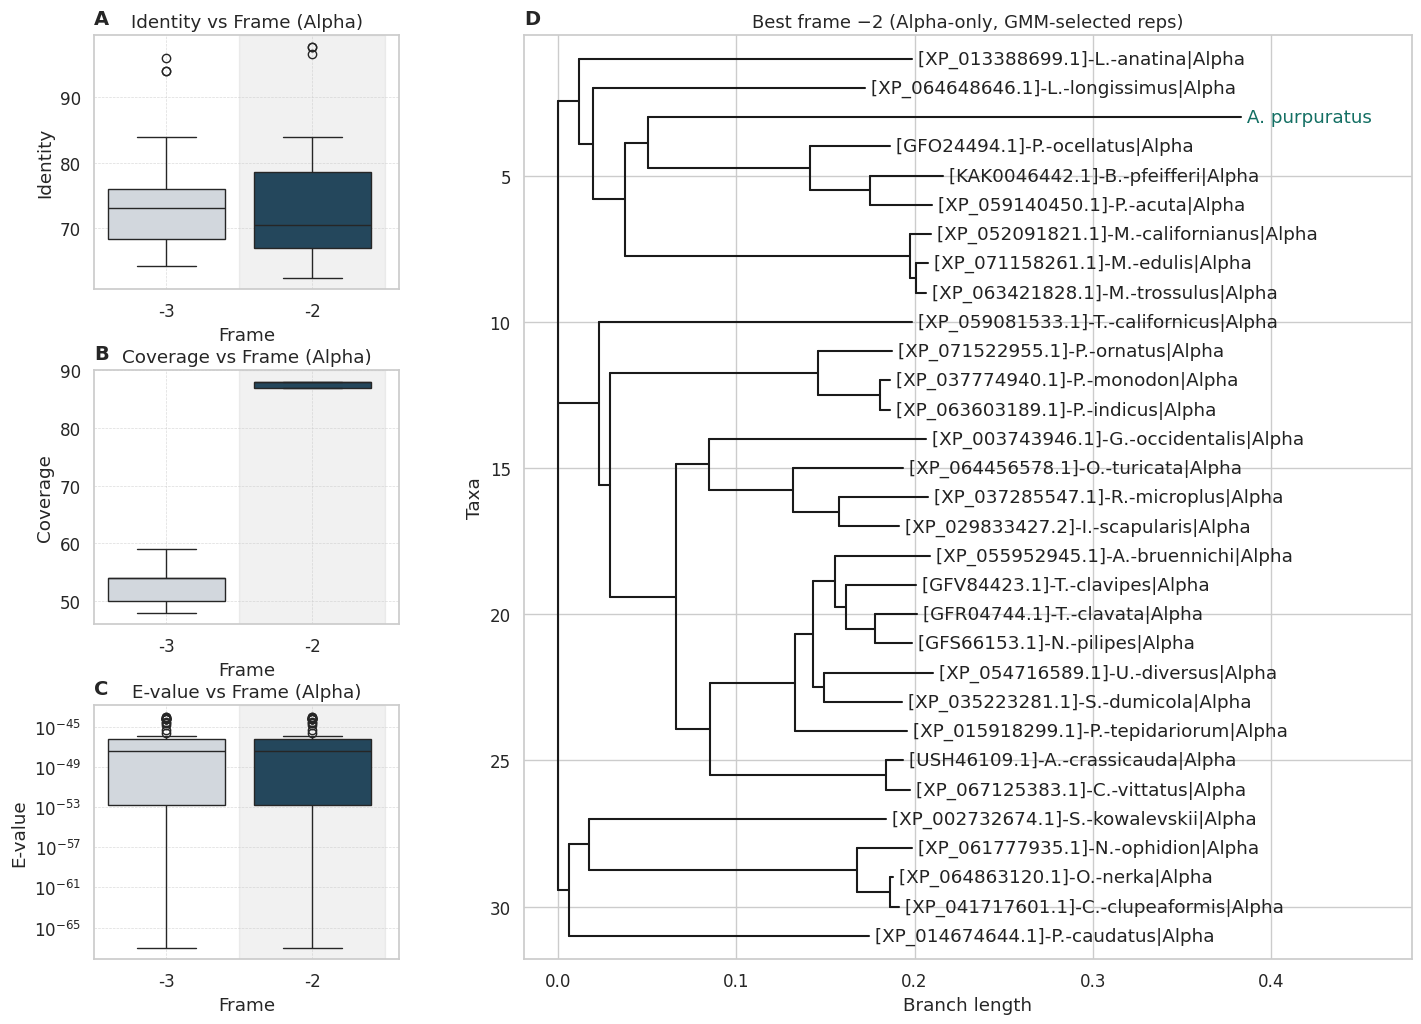

Saved: ../figures_paper/phylo_alpha_gmm_bestframe.png | ../figures_paper/phylo_alpha_gmm_bestframe.pdf


In [10]:
# --- Final figure: A–C QC (Alpha) + D tree(best frame) ---
ACCENT = "#1b4965"; MUTED = "#d0d7df"

# Prepare df for boxplots (frame as string to avoid palette mismatches)
df_plot = df.copy()
def to_frame_str(x):
    try: return str(int(float(x)))
    except Exception: return str(x).strip()
df_plot["Frame_str"] = df_plot["Frame"].apply(to_frame_str)
order = sorted(df_plot["Frame_str"].dropna().unique(), key=lambda z: int(z))
palette = {lvl: (ACCENT if int(lvl) == int(best_frame) else MUTED) for lvl in order}
pos_sel = order.index(str(int(best_frame))) if str(int(best_frame)) in order else None

def _shade_selected(ax, pos):
    if pos is not None:
        ax.axvspan(pos - 0.5, pos + 0.5, color="k", alpha=0.06, zorder=0)

selected_tree = tree_f2 if best_frame == -2 else tree_f3
best_label = "−2" if best_frame == -2 else "−3"

fig = plt.figure(figsize=(17, 12), constrained_layout=False)
gs = plt.GridSpec(nrows=3, ncols=3, figure=fig,
                  width_ratios=[1.0, 1.25, 1.25], wspace=0.35, hspace=0.32)

axA = fig.add_subplot(gs[0, 0])
axB = fig.add_subplot(gs[1, 0])
axC = fig.add_subplot(gs[2, 0])
axD = fig.add_subplot(gs[:, 1:])

# A
sns.boxplot(data=df_plot, x="Frame_str", y="Identity", ax=axA, order=order, palette=palette)
_shade_selected(axA, pos_sel)
axA.set_xlabel("Frame"); axA.set_title(f"Identity vs Frame (Alpha)")
axA.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# B
sns.boxplot(data=df_plot, x="Frame_str", y="Coverage", ax=axB, order=order, palette=palette)
_shade_selected(axB, pos_sel)
axB.set_xlabel("Frame"); axB.set_title("Coverage vs Frame (Alpha)")
axB.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# C
sns.boxplot(data=df_plot, x="Frame_str", y="E-value", ax=axC, order=order, palette=palette)
_shade_selected(axC, pos_sel)
axC.set_yscale("log"); axC.set_xlabel("Frame"); axC.set_title("E-value vs Frame (Alpha)")
axC.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# D
draw_tree_ax(selected_tree, axD, f"Best frame {best_label} (Alpha-only, GMM-selected reps)")

# Panel letters
for ax, L in [(axA,"A"),(axB,"B"),(axC,"C"),(axD,"D")]:
    add_panel_letter(fig, ax, L)

fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
fig.savefig(OUT_PDF, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", OUT_PNG, "|", OUT_PDF)